In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA, ARMA, arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [2]:
# 设置图片参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小
plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

In [3]:
def error_prop(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [4]:
def parse_date(str):
    return datetime.strptime(str, '%Y-%m-%d')

## 1 数据预处理

In [5]:
# 加载数据
data_path = "../../data/luggage_compartment_door.txt"
df = pd.read_csv(data_path, sep='\t')

# 重新命名列名
df.rename(columns={'物料编码': 'part_id', '物料描述': 'part_name', 
                   '订货数': 'order_num', '缺件数': 'out_of_stock_num', 
                   '受理数': 'delivery_num', '审核日期': 'date', '审核时间': 'time'}, inplace=True)

# 将`part_id`的数据类型设为字符串，方便后面进行重采样 
df['part_id'] = df['part_id'].astype('str')

# 重置索引
# df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df.set_index('date', inplace=True)

# 按照时间排序
df.sort_index(inplace=True)

In [6]:
# 重采样
df_day = df.resample('D').sum()

In [7]:
# 截取2018年的数据
df_2018 = df_day['2018']

In [8]:
# 截取2017年的数据
df_2017 = df_day['2017']

In [9]:
# 截取2016年的数据
df_2016 = df_day['2016']

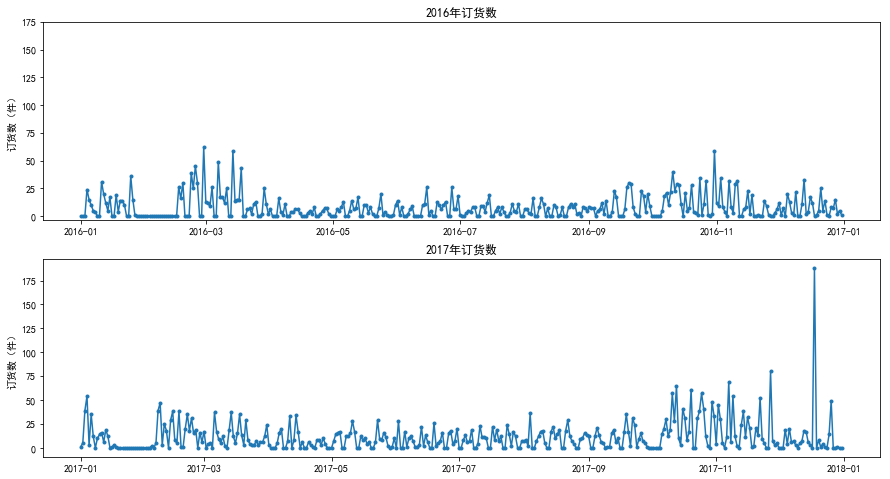

In [11]:
plt.subplot(2, 1, 1)
plt.plot(df_2016.order_num, '.-')
plt.title('2016年订货数')
plt.ylabel('订货数（件）')
plt.yticks(range(0, 200, 25))

plt.subplot(2, 1, 2)
plt.plot(df_2017.order_num, '.-')
plt.title('2017年订货数')
plt.ylabel('订货数（件）')
# plt.yticks(range(0, 140, 20))

plt.show()

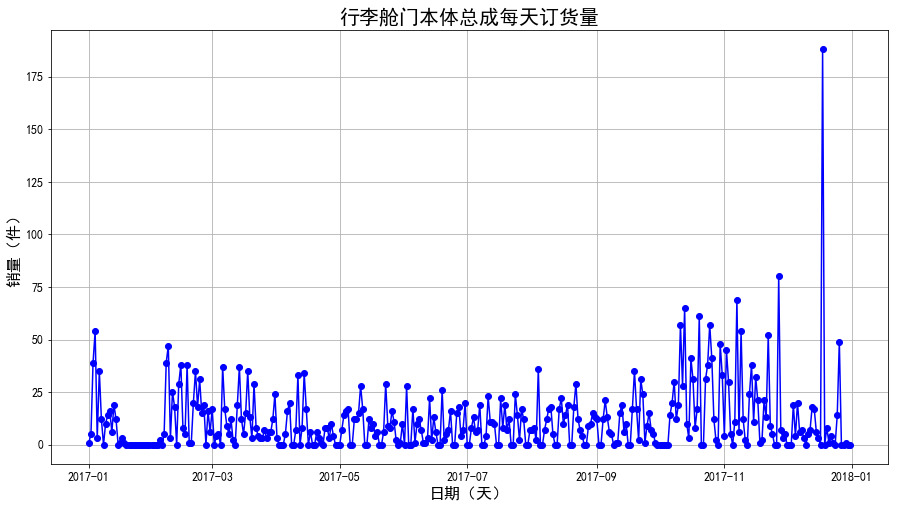

In [10]:
fig, ax = plt.subplots()
ax.plot(df_2017.order_num, 'bo-')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 2 主要是星期几订货？

In [11]:
df_2018['weekday_name'] = df_2018.index.weekday_name

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
no_order_day = df_2018[df_2018.order_num == 0.0]
print("2018年没有订货的天数为：%s天" % len(no_order_day))

2018年没有订货的天数为：64天


In [13]:
no_order_counts = no_order_day.weekday_name.value_counts()

In [14]:
no_order_counts / len(no_order_day)

Sunday       0.421875
Saturday     0.203125
Thursday     0.093750
Tuesday      0.093750
Wednesday    0.078125
Friday       0.062500
Monday       0.046875
Name: weekday_name, dtype: float64

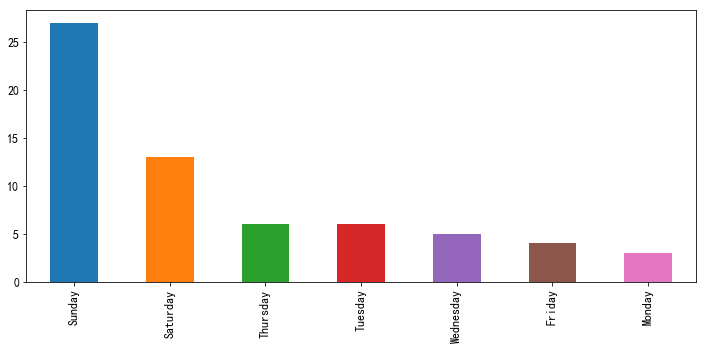

In [15]:
no_order_counts.plot(kind='bar', figsize=(12, 5), fontsize=12)

主要是星期六天没有订货，占比 **62.5%**。

In [16]:
order_day = df_2018[df_2018.order_num > 0.0]

In [17]:
print("2018年里订货的天数为：%s" % (len(order_day)))

2018年里订货的天数为：205


In [18]:
order_counts = order_day.weekday_name.value_counts()

In [19]:
order_counts / len(order_day)

Monday       0.175610
Friday       0.165854
Wednesday    0.165854
Tuesday      0.160976
Thursday     0.156098
Saturday     0.121951
Sunday       0.053659
Name: weekday_name, dtype: float64

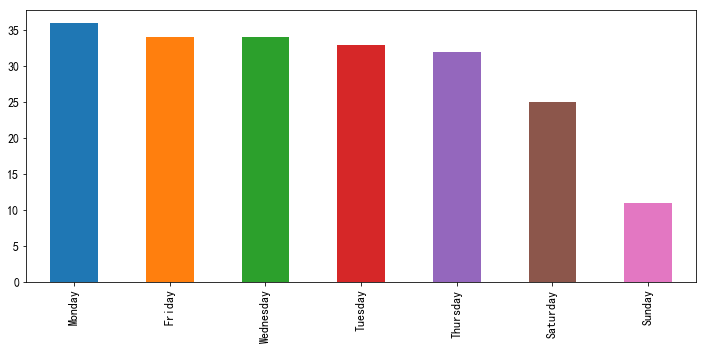

In [20]:
order_counts.plot(kind='bar', figsize=(12, 5), fontsize=12)

<u>**2018年里的订货日期比较平均**</u>，除了星期天略少一些。

## 3 较大的订货量主要发生在星期几？

In [21]:
big_order_day = df_2018[df_2018.order_num >= 40]

In [22]:
print("2018年订货数非常大的天数有 %s 天" % len(big_order_day))

2018年订货数非常大的天数有 17 天


In [23]:
big_order_counts = big_order_day.weekday_name.value_counts()

In [24]:
big_order_counts / len(big_order_day)

Tuesday      0.294118
Monday       0.235294
Friday       0.176471
Wednesday    0.117647
Thursday     0.117647
Saturday     0.058824
Name: weekday_name, dtype: float64

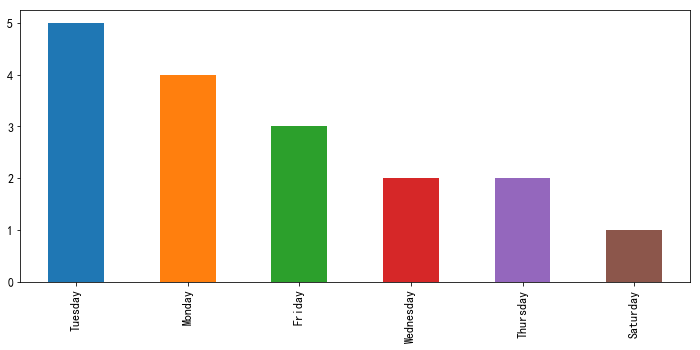

In [25]:
big_order_counts.plot(kind='bar', figsize=(12, 5), fontsize=12)

## 建模探索

In [26]:
print("2018年到目前为止总的订货量：%s" % order_day.order_num.sum())

2018年到目前为止总的订货量：2734.0


In [27]:
print("2018年有订货的日期中平均每天订货数：%s" % order_day.order_num.mean())

2018年有订货的日期中平均每天订货数：13.336585365853658


In [28]:
print("2018年有订货的日期中订货数的中位数：%s" % order_day.order_num.median())

2018年有订货的日期中订货数的中位数：7.0


In [29]:
df_201703_to_201709 = df_2017['2017-03':'2017-09']

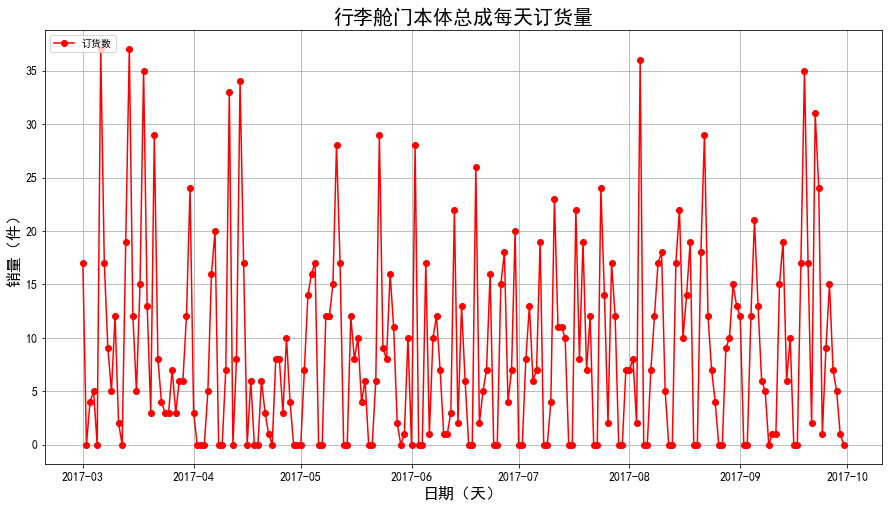

In [30]:
fig, ax = plt.subplots()
ax.plot(df_201703_to_201709.order_num, 'ro-', label='订货数')
# ax.plot(df_201807_to_201809.out_of_stock_num, 'go-', label='缺货数')
# ax.plot(df_201807_to_201809.delivery_num, 'bo-', label='受理数')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [31]:
train_day = df_201703_to_201709
test_day = df_201703_to_201709['2017-09']

## 2 时间序列检验

### 2.1 自相关图和偏自相关图

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


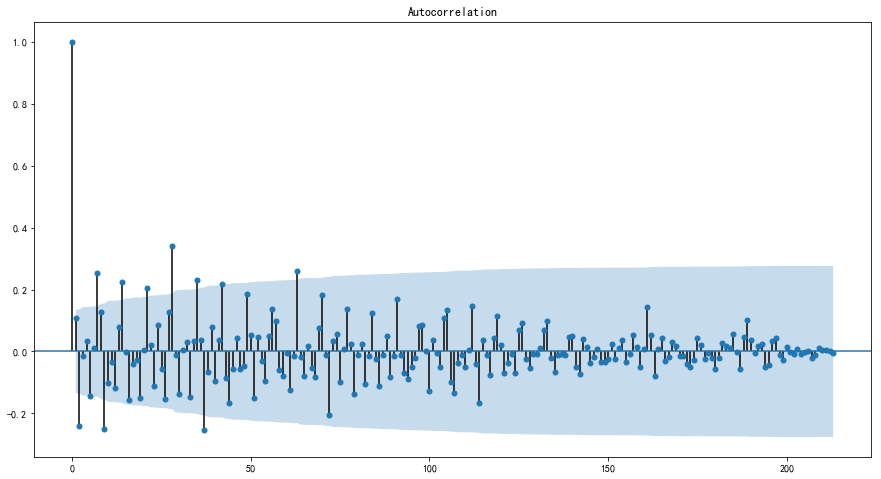

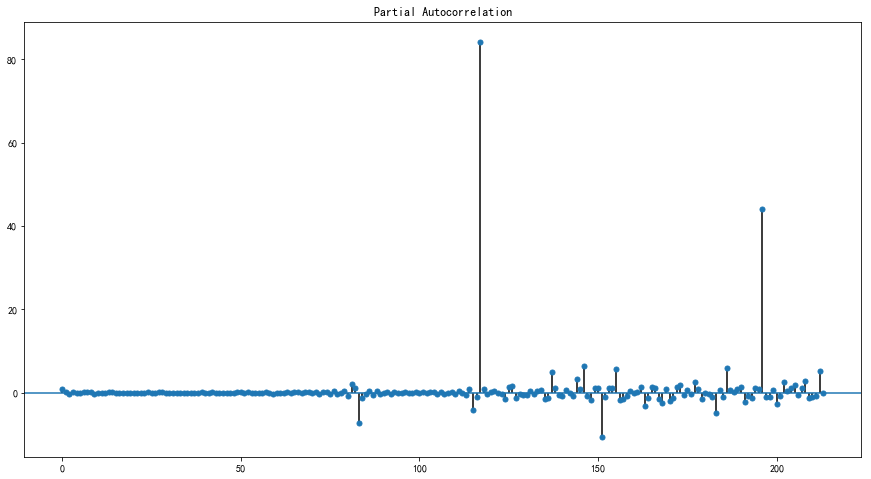

In [32]:
# 天的自相关图
plot_acf(df_201703_to_201709.order_num.values).show()
plot_pacf(df_201703_to_201709.order_num.values).show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


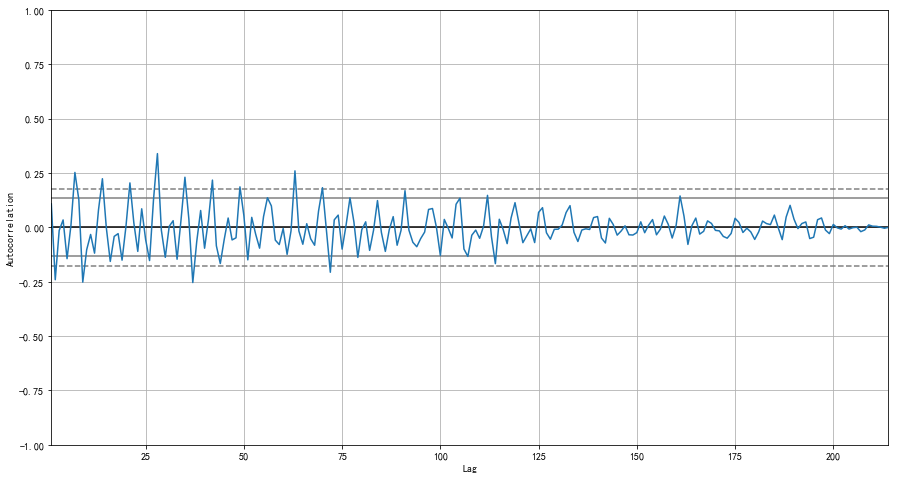

In [33]:
autocorrelation_plot(df_201703_to_201709.order_num.values)
plt.show()

### 2.2 单位根检验

In [34]:
adf_result = adfuller(df_201703_to_201709.order_num.values)
output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("单位根检验结果为：")
print(output)

单位根检验结果为：
                                   value
Test Statistic Value            -4.25512
p-value                      0.000530791
Lags Used                             12
Number of Observations Used          201
Critical Value (1%)             -3.46331
Critical Value (5%)             -2.87603
Critical Value (10%)            -2.57449


### 2.3 纯随机性检验

In [35]:
print("序列的纯随机性检验结果为：", end='')
print(acorr_ljungbox(df_201703_to_201709.order_num.values, lags=1)[1][0])

序列的纯随机性检验结果为：0.11191354335670274


## 3 模型拟合

### 3.1 Holt-Winters method

In [36]:
train, test = train_day.order_num.values, test_day.order_num.values

In [37]:
model = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add')
model_fit = model.fit()
preds = model_fit.forecast(len(test))

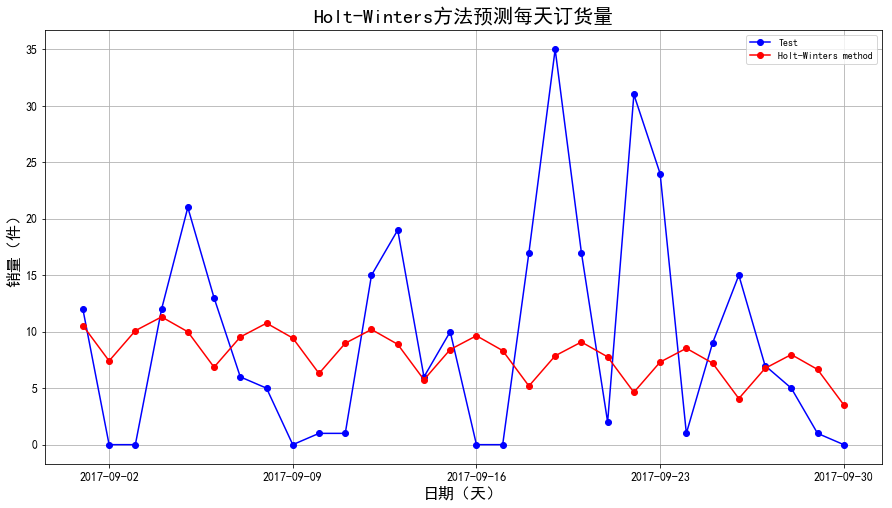

In [38]:
fig, ax = plt.subplots()
# ax.plot(train_day.index, train_day.order_num.values, 'go-', label='Train')
ax.plot(test_day.index, test, 'bo-', label='Test')
ax.plot(test_day.index, preds, 'ro-', label='Holt-Winters method')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('Holt-Winters方法预测每天订货量', fontsize=20)
ax.legend(loc='best')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [39]:
rmse = sqrt(mean_squared_error(test, preds))
print("The RMSE of 'Holt-Winters method' is:", rmse)

The RMSE of 'Holt-Winters method' is: 10.021058723499937


In [40]:
print("The error proportion of Holt-Winters is:", error_prop(test, preds))

The error proportion of Holt-Winters is: 0.8134685067900529


### 3.2 ARIMA

In [41]:
train, test = train_day.order_num.values, test_day.order_num.values

In [26]:
# pmax = len(df_day) // 10
# qmax = len(df_day) // 10 

pmax = 6
qmax = 6

bic_matrix = [] 
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try: 
            temp.append(ARIMA(train, (p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix).astype('float').dropna(axis=1)
p, q = bic_matrix.stack().idxmin()
print("AIC最小的(p, q)值为：(%s, %s)" % (p, q))

bic_matrix = [] 
for p in range(pmax + 1):
    temp = []
    for q in range(qmax + 1):
        try: 
            temp.append(ARIMA(train, (p, 0, q)).fit().aic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix).astype('float').dropna(axis=1)
p, q = bic_matrix.stack().idxmin()
print("AIC最小的(p, q)值为：(%s, %s)" % (p, q))

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC最小的(p, q)值为：(2, 0)


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC最小的(p, q)值为：(2, 0)


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [42]:
arma_order_select_ic(train, max_ar=6, max_ma=6, ic='aic')['aic_min_order']

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmo

(4, 4)

In [43]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = ARMA(history, order=(4, 4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat[0])
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

expected = 12.000000 predicted = 1.791277
expected = 0.000000 predicted = 11.348000
expected = 0.000000 predicted = 13.133350
expected = 12.000000 predicted = 11.698497


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


expected = 21.000000 predicted = 11.153612
expected = 13.000000 predicted = 7.642253
expected = 6.000000 predicted = 2.913322


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


expected = 5.000000 predicted = 4.836522


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


expected = 0.000000 predicted = 10.728287
expected = 1.000000 predicted = 10.468660


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1.000000 predicted = 11.454457
expected = 15.000000 predicted = 13.843913
expected = 19.000000 predicted = 12.172345
expected = 6.000000 predicted = 6.235750
expected = 10.000000 predicted = 3.596101
expected = 0.000000 predicted = 7.016440
expected = 0.000000 predicted = 7.100222
expected = 17.000000 predicted = 8.853812
expected = 35.000000 predicted = 15.943654
expected = 17.000000 predicted = 15.220532
expected = 2.000000 predicted = 4.303793
expected = 31.000000 predicted = 0.962155
expected = 24.000000 predicted = 8.000212
expected = 1.000000 predicted = 6.729040


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


expected = 9.000000 predicted = 4.922917
expected = 15.000000 predicted = 19.970616
expected = 7.000000 predicted = 12.878472
expected = 5.000000 predicted = 2.211145
expected = 1.000000 predicted = 10.902799
expected = 0.000000 predicted = 10.661277
Test RMSE: 9.946


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [44]:
temp = np.array(preds).reshape((len(test), ))
print("The error proportion of ARIMA is:", error_prop(test, temp))

The error proportion of ARIMA is: 0.821645245871051


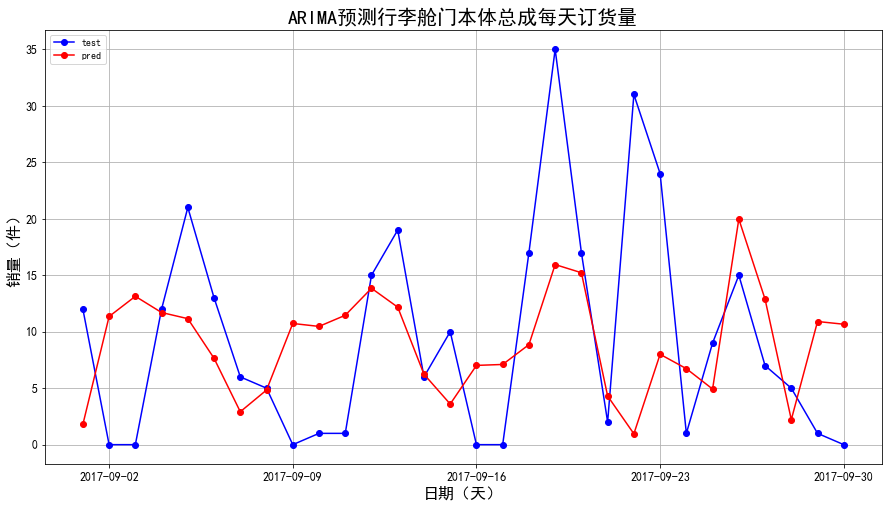

In [45]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test, 'bo-', label='test')
ax.plot(test_day.index, preds, 'ro-', label='pred')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA预测行李舱门本体总成每天订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../../figs/ARIMA预测图.png")
plt.show()

In [46]:
test_day['pred'] = preds

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
result_week = test_day[['order_num', 'pred']].resample('W').sum()

In [54]:
result_week

,order_num,pred
date,,
2017-09-03,12.0,26.272627
2017-09-10,58.0,59.441153
2017-09-17,51.0,61.419229
2017-09-24,127.0,60.013198
2017-10-01,37.0,61.547225


In [55]:
result_week['pred']['2017-09-24'] = 120

In [63]:
result_week['pred']['2017-10-01'] = 45

In [42]:
error_prop(result_week.order_num, result_week.preds)

0.12307336347245021

In [43]:
sqrt(mean_squared_error(result_week.order_num, result_week.preds))

10.246950765959598

In [14]:
df_2017_week = df_2017.resample('W').sum()

In [21]:
result_week = df_2017_week['2017-12'][['order_num']]

In [37]:
result_week['preds'] = [90, 75, 50, 190, 72]

In [38]:
result_week

,order_num,preds
date,,
2017-12-03,95.0,90
2017-12-10,59.0,75
2017-12-17,56.0,50
2017-12-24,202.0,190
2017-12-31,64.0,72


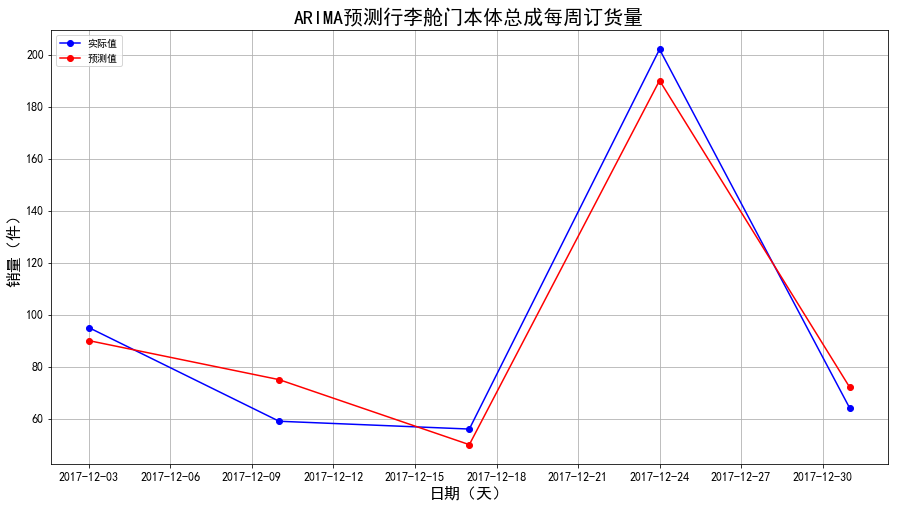

In [41]:
fig, ax = plt.subplots()
ax.plot(result_week.order_num, 'bo-', label='实际值')
ax.plot(result_week.preds, 'ro-', label='预测值')
ax.set_xlabel('日期（天）', fontsize=16)
ax.set_ylabel('销量（件）', fontsize=16)
ax.set_title('ARIMA预测行李舱门本体总成每周订货量', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../../figs/ARIMA预测行李舱门本体总成每周订货量.png")
plt.show()

### 3.3 SARIMAX

In [29]:
train, test = train_day.order_num.values, test_day.order_num.values

NameError: name 'train_month' is not defined

In [ ]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 6)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(train,
                              order = param,
                              seasonal_order = param_seasonal,
                              enforce_stationarity=True,
                              enforce_invertibility=True)
            res = tmp_mdl.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [30]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = SARIMAX(train, order=(5, 0, 4), seasonal_order=(0, 1, 1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("expected = %f predicted = %f" % (obs, yhat))
error = sqrt(mean_squared_error(test, preds))
print("Test RMSE: %.3f" % error)

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 444.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 7012.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5608.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4344.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 80.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 0.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1828.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 568.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1212.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 144.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 396.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 100.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 100.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 308.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 440.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 5136.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 72.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 296.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 172.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 124.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 372.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3196.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 3584.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 1960.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 992.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 4.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 120.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 0.000000 predicted = 875.123609


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


expected = 616.000000 predicted = 875.123609
expected = 996.000000 predicted = 875.123609
Test RMSE: 1947.732


D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


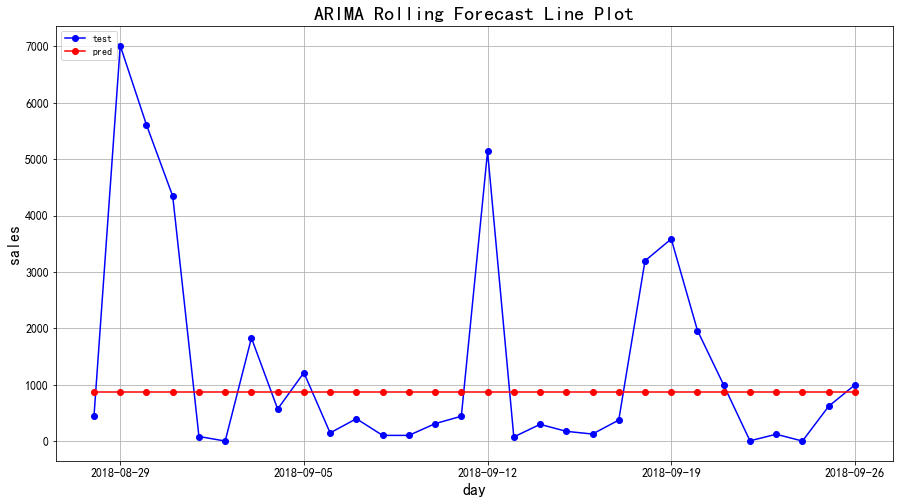

In [31]:
fig, ax = plt.subplots()
ax.plot(test_day.index, test, 'bo-', label='test')
ax.plot(test_day.index, preds, 'ro-', label='pred')
ax.set_xlabel('day', fontsize=16)
ax.set_ylabel('sales', fontsize=16)
ax.set_title('ARIMA Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()